# Confidence intervals case study using NHANES data


This notebook demonstrates how to use Python and its statistical libraries to construct confidence intervals for proportions and means.  We will also cover some important points relating to the properties of confidence intervals, and discuss how to use and interpret confidence intervals in practice.  We will use the 2015-2016 wave of the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data for all the analyses below.

It is important to note that the NHANES data are a "complex survey".  The data are not an independent and representative sample from the target population.  Proper analysis of complex survey data should make use of additional information about the manner in which the data were collected.  Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

The following module import statements and data reading statement are identical to what we have used previously in course 1.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

We can now read the data into Python using the [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function:

In [3]:
da = pd.read_csv("nhanes_2015_2016.csv")

## Confidence intervals for one proportion

In this section, we demonstrate the construction of confidence intervals for the proportion of people who smoke.  The specific definition of "smoker" used here ([SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020)) identifies a person as being a smoker if they self-report as having smoked 100 or more cigarettes in their lifetime.  It is more accurate to refer to this as a measure of "lifetime smoking" rather than "current smoking".  Recall that the definitions of these and other NHANES variables can be found using the NHANES code books, or by searching using the link below.

https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx

We will calculate the proportions of smokers separately for females and for males.  Initially we can compare these two proportions and their corresponding confidence intervals informally, but later we will discuss methods to compare two proportions formally using confidence intervals.

First we replace the numeric codes in the variables of interest with text labels, and set the rare answers other than "yes" and "no" to be missing (so they will automatically be omitted from all the analyses below).

In [4]:
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

We can now [tabulate](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html) the numbers of female and male smokers and non-smokers:

In [5]:
dx = da[["SMQ020x", "RIAGENDRx"]].dropna()  # dropna drops cases where either variable is missing
pd.crosstab(dx.SMQ020x, dx.RIAGENDRx)

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


The confidence interval (CI) is constructed using two inputs: the sample proportion of smokers, and the total sample size for smokers and non-smokers combined.  We calculate these values next.

Text(0, 0.5, 'Proportion')

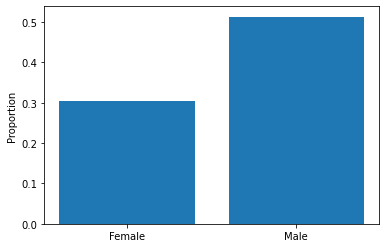

In [15]:
dz = dx.groupby(dx.RIAGENDRx).agg({"SMQ020x": [lambda x: np.mean(x=="Yes"), np.size]})
dz.columns = ["Proportion", "Total_n"] # The default column names are unclear, so we replace them here
dz

plt.bar(dz.index, dz.Proportion)
plt.ylabel("Proportion")
#plt.scatter(dz.index, dz.Proportion)

Confidence intervals are closely connected to standard errors.  Recall that the standard error essentially tells you how
far you should expect an estimate to fall from the truth.  A confidence interval is an interval that under repeated sampling covers the truth a defined proportion of the time.  In most settings, this "coverage probability" is set to 95%.  

It turns out that in many settings, a 95% confidence interval can be constructed as the interval consisting of all points that are within two (or 1.96) standard errors of the point estimate.  More concisely, the confidence interval approximately spans from e - 2•SE to e + 2•SE, where e is the point estimate and SE is the standard error.

Since the standard error plays such an important role here, we calculate it separately first.

0.008444152146214435
0.009526078653689868


<BarContainer object of 2 artists>

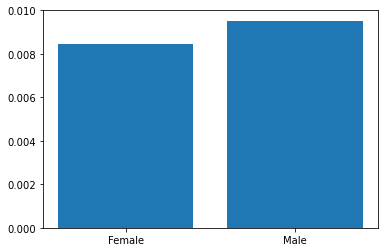

In [12]:
p = dz.Proportion.Female # Female proportion
n = dz.Total_n.Female # Total number of females
se_female = np.sqrt(p * (1 - p) / n)
print(se_female)

p = dz.Proportion.Male # Male proportion
n = dz["Total_n"].Male # Total number of males
se_male = np.sqrt(p * (1 - p) / n)
print(se_male)

plt.bar(dz.index, [se_female, se_male])

We can see that the standard errors for the estimated proportions of females and males who smoke are similar, and are each around 1% (since we are studying a proportion here, 0.01 corresponds to a 1 percentage point change in the smoking rate).  

The standard error for a proportion is maximized when the true proportion is around 1/2, and gets smaller as the true proportion approaches either 0 or 1.  The estimated male smoking proportion is closer to 1/2 than the estimated female smoking proportion, and the male sample size is smaller than the female sample size.  Both of these factors lead to the male standard error being larger than the female standard error, although the difference is very small in this case.

Next we calculate the 95% confidence intervals for the proportions of female and male smokers using the formula for the one-sample confidence interval for a proportion:

In [16]:
p = dz.Proportion.Female # Female proportion
n = dz.Total_n.Female # Total number of females
lcb = p - 1.96 * np.sqrt(p * (1 - p) / n)  
ucb = p + 1.96 * np.sqrt(p * (1 - p) / n)  
print(lcb, ucb)

0.288294683866098 0.32139576027925865


The results above indicate that any population proportion (for female lifetime smokers) between 0.288 and 0.321 would be compatible with the data that we observed in NHANES.

In [18]:
p = dz.Proportion.Male # Male proportion
n = dz.Total_n.Male # Total number of males
lcb = p - 1.96 * np.sqrt(p * (1 - p) / n)  
ucb = p + 1.96 * np.sqrt(p * (1 - p) / n)  
print(lcb, ucb)

0.49458714955108174 0.531929377873546


These results indicate that any population proportion (for male lifetime smokers) between 0.493 and 0.531 would be compatible with the NHANES data.

In a routine data analysis, we do not need to calculate these intervals manually.  We can use the Statsmodels library to calculate the CI for us in one line:

In [19]:
# 95% CI for the proportion of females who smoke (compare to value above)
sm.stats.proportion_confint(906, 906+2066)  

(0.2882949879861214, 0.32139545615923526)

In [20]:
# 95% CI for the proportion of males who smoke (compare to value above)
sm.stats.proportion_confint(1413, 1413+1340)  

(0.49458749263718593, 0.5319290347874418)

## Confidence intervals comparing two independent proportions

The confidence intervals for the proportions of female and male smokers shown above are quite narrow and do not overlap.  This suggests that there is a substantial difference between the lifetime smoking rates for women and men. However there is no explicit information here about how different the two population proportions might be.  To address this question, we can form a confidence interval for the difference between the proportion of females who smoke and the proportion of males who smoke.  

The point estimate of the difference between female and male smoking rates is -0.208 (0.305 - 0.513).  That is, the smoking rate is about 20 percentage points higher in men than in women.  This difference of around 20 percentage points is only a point estimate of the underlying true value -- it is not exactly equal to the difference between the unknown proportions of females and males who smoke in the population.  A confidence interval helps us assess how far the estimated difference may be from the true difference.

As above, we start with the standard error.  The difference between two sample proportions based on independent data has a standard error that reflects the combined uncertainty in the two proportions being differenced.  This standard error can be calculated very easily.  If SE1 and SE2 are the standard errors for two proportions, then sqrt(SE1^2 + SE2^2) is the standard error for the difference of these proportions (`sqrt` is the square root function).  Note that this formula is only accurate if the two sample proportions being differenced are independent.

In the next cell we calculate the standard error for the difference between the proprotion of females who smoke and the proportion of males who smoke.

In [162]:
se_diff = np.sqrt(se_female**2 + se_male**2)
se_diff

0.012729881381407434

The standard error of around 0.013 indicates that the estimated difference statistic -0.208 is expected to fall around 0.013 units from the true value.  We do not know in which direction the error lies, and we do not know that the error is exactly 0.013, only that it is around this large on average.  For most purposes, a standard error of 0.013 relative to an observed difference of -0.21 would be considered very small.  That is, we have a very accurate estimate of the difference between smoking rates in women and in men.

Now that we have the standard error, we can construct a 95% confidence interval for the difference in proportions by taking the estimate and subtracting and adding two (or 1.96) standard errors from it.

In [163]:
d = dz.Proportion.Female - dz.Proportion.Male
lcb = d - 2*se_diff
ucb = d + 2*se_diff
print(lcb, ucb)
print(d1, d)

-0.233872804402 -0.182953278877
-0.20841304164 -0.20841304164


The 95% confidence interval above shows us that any value for the difference of population proportions (between females and males) lying between -0.233 and -0.183 is consistent with the observed data.

### Confidence intervals for subpopulations

Since smoking rates vary strongly with age, it might be more informative to stratify the data into homogeneous age bands and compare the proportions of female and male smokers within each age band.  We can also calculate the 95% confidence interval for this difference within each age band.  These data can be displayed as a plot, with the difference in proportions plotted as a curve.  The confidence intervals can then be used to construct a "confidence band" around the estimates.

/home/tom/anaconda3/envs/math-module/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tom/anaconda3/envs/math-module/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tom/anaconda3/envs/math-module/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

Text(0, 0.5, 'Female - male smoking proportion')

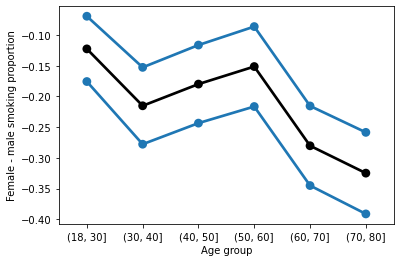

In [21]:
# Calculate the smoking rates within age/gender groups
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = da.groupby(["agegrp", "RIAGENDRx"]).agg({"SMQ020x": lambda x: np.mean(x=="Yes")}).unstack()
pr.columns = ["Female", "Male"]

# The number of people for each calculated proportion
dn = da.groupby(["agegrp", "RIAGENDRx"]).agg({"SMQ020x": np.size}).unstack()
dn.columns = ["Female", "Male"]

# Standard errors for each proportion
se = np.sqrt(pr * (1 - pr) / dn)

# Standard error for the difference in female/male smoking rates in every age band
se_diff = np.sqrt(se.Female**2 + se.Male**2)

# Standard errors for the difference in smoking rates between genders, within age bands

# The difference in smoking rates between genders
pq = pr.Female - pr.Male

x = np.arange(pq.size)
pp = sns.pointplot(x, pq.values, color='black')
sns.pointplot(x, pq - 2*se_diff)
sns.pointplot(x, pq + 2*se_diff)
pp.set_xticklabels(pq.index)
pp.set_xlabel("Age group")
pp.set_ylabel("Female - male smoking proportion")

The plot above shows for each age band, the point estimate of the difference in smoking rates between genders (black dot), and the lower and upper end points of the 95% confidence interval (blue points).  Based on this plot, we see that in the United States, smoking is more common in men than in women, not just overall, but also in every one of the age bands.  The difference is largest for older people -- for people older than 60, the smoking rate for males is around 30 percentage points greater than the smoking rate for females, while for people younger than 30, the smoking rate for males is only around 15 percentage points greater than the smoking rate for females.

Also note that the 95% confidence bands shown above are much wider than the 95% confidence intervals for the data that were not stratified by age.  Stratifying by age leads to smaller sample sizes, which in turn results in wider confidence intervals.

## Confidence intervals for the mean

In this section, we discuss how to construct confidence intervals for the mean.  First note that the proportion discussed above is also a mean -- for example, if the data are 0, 1, 0, then the mean is 1/3, which is also the proportion of 1's in the data.  However the proportion has the special property that the variance is completely determined by the mean. That is why we constructed the standard errors for the sample proportion above using p•(1 - p) as the variance.  In general, the variance of quantitative data will not be a function of the mean, as this is a very special property of binary data.  Therefore, in general we must estimate the variance as a separate step after estimating the mean. 

To illustrate the construction of confidence intervals for the population mean of a quantitative variable, we will use the body mass inde (BMI) data from NHANES.  To begin, we calculate the mean BMI for all women and for all men in the NHANES sample.

In [165]:
da.groupby("RIAGENDRx").agg({"BMXBMI": np.mean})

,BMXBMI
RIAGENDRx,
Female,29.939946
Male,28.778072


The numbers in the first column of the table above are estimates of the population mean BMI for all women and for all men in the United States (the population that the NHANES study represents). As with the sample proportions, these numbers are not exactly equal to the mean BMI for all women and men, they are only estimates.  To establish the uncertainty for these estimates, we can use the standard errors for these two estimated means.

The standard error for the mean based on an independent and identically distributed sample is equal to the standard deviation of the variable divided by the square root of the sample size.  We next calculate all the relevant values needed to compute the standard error. 

In [166]:
da.groupby("RIAGENDRx").agg({"BMXBMI": [np.mean, np.std, np.size]})

BMXBMI                  
                mean       std    size
RIAGENDRx                             
Female     29.939946  7.753319  2976.0
Male       28.778072  6.252568  2759.0

We can now calculate the standard error of the mean BMI for women and for men:

In [167]:
sem_female = 7.753 / np.sqrt(2976)
sem_male = 6.253 / np.sqrt(2759)
print(sem_female, sem_male)

0.142119385345 0.119045388988


We see that the sample mean BMI for women is expected to be off by around 0.14 relative to the population mean BMI for women, and the sample mean BMI for men is expected to be off by around 0.12 relative to the population mean BMI for men.

The standard error of the mean for women is slightly larger for women than for men.  The reason for this is that even though the NHANES sample size for women is slightly larger than that for men, the data for women appears to be more spread out.  The greater standard deviation for the female BMI values leads in turn to less precision when estimating the population mean BMI for females. 

As was the case for proportions, the 95% confidence interval for the mean can be calculated by taking the estimate plus and minus 2 (or 1.96) times the standard error.  The 95% confidence interval for female BMI is thus calculated as follows:

In [168]:
lcb_female = 29.94 - 1.96 * 7.753 / np.sqrt(2976)
ucb_female = 29.94 + 1.96 * 7.753 / np.sqrt(2976)
print(lcb_female, ucb_female)

29.6614460047 30.2185539953


Below we show how the one-sample confidence interval can be calculated using Statsmodels.  The numbers differ slightly
due to rounding in the calculation above.  The result below is more exact.

In [169]:
female_bmi = da.loc[da.RIAGENDRx=="Female", "BMXBMI"].dropna()
sm.stats.DescrStatsW(female_bmi).zconfint_mean()

(29.659875498090155, 30.220015806257681)

### Confidence intervals for the difference between two means

Now we turn to studying the difference between two means, taking the difference between mean female and male BMI for illustration.  As discussed above, the standard error for the difference of two means taken from independent samples is sqrt(SE1^2 + SE2^2), where SE1 and SE2 are the standard errors for the two means being compared.  Below we see that this gives us a value around 0.19 when comparing the female BMI to the male BMI.  This is substantially larger than either the SEM for estimating the female mean (0.14) or the SEM for estimating the male mean (0.12).  It is expected that the standard error for the difference between two means is greater than the standard errors for estimating a single mean, since the uncertainty of both gender-specific proportions impacts the statistic.

In [170]:
sem_diff = np.sqrt(sem_female**2 + sem_male**2)
sem_diff

0.18539073420811059

We can can now construct a 95% confidence interval for the difference between the female and male mean BMI.

In [171]:
bmi_diff = 29.94 - 28.78
lcb = bmi_diff - 2*sem_diff
ucb = bmi_diff + 2*sem_diff
(lcb, ucb)

(0.78921853158377897, 1.5307814684162213)

This finding indicates that while the point estimate shows that the women in our sample have around 1.1 unit greater BMI than the men in our sample, the true difference between the mean for all women in the population and for all men in the population could fall between 0.79 and 1.53, and still be consistent with the observed data.

**Age-stratified confidence intervals** As a final example, we refine the analysis above by considering the difference of mean BMI values between females and males within age bands.  We see below that the overall average difference of 1.1 units results from differences that are very different based on age.  Specifically, the difference between female and male BMI is much smaller than 1.1 for younger people, and much larger than 1.1 for older people.  

Since the confidence bands for people under 40 contain 0, the data are consistent with there being no difference between female and male BMI in this age range.  For people older than 40, a hypothetical zero difference between the mean BMI values for females and males is not very consistent with the data.  Informally, we can say that the data strongly suggest that the female mean BMI is greater than the male mean BMI in this age band, with the difference being anywhere from 0.5 to 2 units.

Text(0,0.5,'Female - male BMI difference')

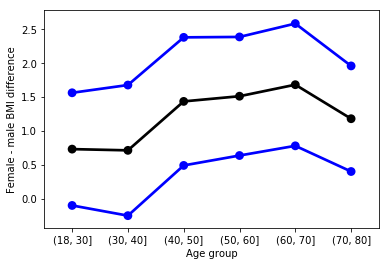

In [172]:
# Calculate the mean, SD, and sample size for BMI within age/gender groups
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = da.groupby(["agegrp", "RIAGENDRx"]).agg({"BMXBMI": [np.mean, np.std, np.size]}).unstack()

# Calculate the SEM for females and for males within each age band
pr["BMXBMI", "sem", "Female"] = pr["BMXBMI", "std", "Female"] / np.sqrt(pr["BMXBMI", "size", "Female"]) 
pr["BMXBMI", "sem", "Male"] = pr["BMXBMI", "std", "Male"] / np.sqrt(pr["BMXBMI", "size", "Male"]) 

# Calculate the mean difference of BMI between females and males within each age band, also  calculate
# its SE and the lower and upper limits of its 95% CI.
pr["BMXBMI", "mean_diff", ""] = pr["BMXBMI", "mean", "Female"] - pr["BMXBMI", "mean", "Male"]
pr["BMXBMI", "sem_diff", ""] = np.sqrt(pr["BMXBMI", "sem", "Female"]**2 + pr["BMXBMI", "sem", "Male"]**2) 
pr["BMXBMI", "lcb_diff", ""] = pr["BMXBMI", "mean_diff", ""] - 1.96 * pr["BMXBMI", "sem_diff", ""] 
pr["BMXBMI", "ucb_diff", ""] = pr["BMXBMI", "mean_diff", ""] + 1.96 * pr["BMXBMI", "sem_diff", ""] 

# Plot the mean difference in black and the confidence limits in blue
x = np.arange(pr.shape[0])
pp = sns.pointplot(x, pr["BMXBMI", "mean_diff", ""], color='black')
sns.pointplot(x, pr["BMXBMI", "lcb_diff", ""], color='blue')
sns.pointplot(x, pr["BMXBMI", "ucb_diff", ""], color='blue')
pp.set_xticklabels(pr.index)
pp.set_xlabel("Age group")
pp.set_ylabel("Female - male BMI difference")

**Inter-group and intra-group differences:** As the sample size grows, estimates become increasingly precise, but it is important to remember that a highly precise estimate for the mean does not imply that individuals within a population do not vary from each other.  To put the differences shown above in context, below we show the underlying summaries on which the plot above was based.  Note that the standard deviation of BMI within both females and males ranges from around 5 to around 8 depending on the age band.  This means, for example, that two randomly-selected males will tend to have BMI values that differ by around 6 units.  This is a far greater difference than the mean difference of up to around 1.5 BMI units between females and males.  Thus, while there is a tendency for females to have slightly higher BMI than males, the heterogeneity within genders is substantially greater than the difference of means between genders.

In [173]:
print(pr)

              BMXBMI                                                         \
                mean                  std             size              sem   
RIAGENDRx     Female       Male    Female      Male Female   Male    Female   
agegrp                                                                        
(18, 30]   28.123881  27.391822  7.745893  6.649440  609.0  544.0  0.313879   
(30, 40]   30.325586  29.611726  8.315608  6.622412  474.0  458.0  0.381949   
(40, 50]   31.160643  29.724623  8.076195  6.407076  502.0  401.0  0.360458   
(50, 60]   30.743777  29.231486  7.575848  5.914373  470.0  454.0  0.349448   
(60, 70]   31.074828  29.392488  7.604514  5.933307  441.0  437.0  0.362120   
(70, 80]   29.138213  27.957692  6.284968  4.974855  410.0  402.0  0.310392   

                                                             
                    mean_diff  sem_diff  lcb_diff  ucb_diff  
RIAGENDRx      Male                                          
agegrp                 

### Confidence intervals and sample size

Confidence intervals reflect the precision of an estimate, which is largely driven by the amount of data used to construct the estimate.  We can explore the relationship between precision and sample size by subampling data from NHANES and calculating confidence intervals for the subsamples.  Below we calculate confidence intervals based on subsamples of size 100, 200, 400, and 800.

A wider confidence interval implies that we have less precision in our estimate.  In the simulation below, we calculate the average width of the confidence intervals constructed for each sample size.  We see that the confidence interval steadily becomes shorter as the sample size grows.  For most settings, the confidence interval will become around half as wide when the sample size is increased by a factor of 4.  Below we see this scaling when the sample size increases from 100 to 400, and when it increases from 200 to 800, both of which are increases by a factor of 4.

In [174]:
dx = da.loc[da.RIAGENDRx=="Female", ["RIAGENDRx", "BMXBMI"]].dropna()

all_cis = []
for n in 100, 200, 400, 800:
    cis = []
    for i in range(500):
        dz = dx.sample(n)
        ci = sm.stats.DescrStatsW(dz.BMXBMI).zconfint_mean()
        cis.append(ci)
    cis = np.asarray(cis)
    mean_width = cis[:, 1].mean() - cis[:, 0].mean()
    print(n, mean_width)
    all_cis.append(cis)

100 3.03569675744
200 2.14396986451
400 1.52339573732
800 1.07282499255


It is also informative to plot the individual confidence intervals, computed for 500 subsamples of size 100, to see how they vary.  The vertical grey bars below each correspond to a confidence interval.  The red horizontal line is the mean BMI calculated using the entire data set, which can be taken as a proxy for othe population mean.  While the individual intervals are quite different from each other, it appears that the vast majority of them cover the population value.

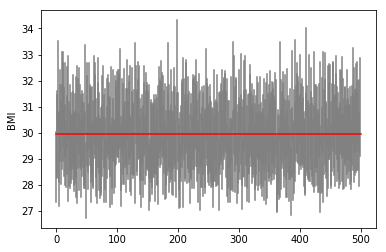

In [175]:
ci = all_cis[0]
for j, x in enumerate(ci):
    plt.plot([j, j], x, color='grey')
    plt.gca().set_ylabel("BMI")
mn = dx.BMXBMI.mean()
plt.plot([0, 500], [mn, mn], color='red')

We can calculate the fraction of the 500 simulated confidence intervals that did not cover the target value.  This is called the "non-coverage probability".  There are two ways for an interval to fail to cover the target -- either the upper limit of the interval can fall below the target, or the lower limit of the interval can fall above the target.  We calculate each of these below.  The sum of these two probabilities should be around 0.05, which is the allowed proportion of the time that a 95% confidence interval does not cover its target.

In [176]:
print(np.mean(ci[:, 1] < mn)) # Upper limit falls below the target
print(np.mean(ci[:, 0] > mn)) # Lower limit falls above the target

0.03
0.018
